In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from diffusion.unet_model import Unet
from diffusion.ddim import DDIM
from diffusion.ddpm import DDPM
from diffusion.pokemon_dataset import PokemonDataset

In [3]:
# set device to cpu or cuda or mps
if torch.backends.mps.is_available():
    device = torch.device('mps') 
    print("Device set to : mps")
elif(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    device = torch.device('cpu')
    print("Device set to : cpu")

Device set to : mps


In [4]:
IMG_SIZE=64
transform = transforms.Compose([
        transforms.ToTensor(), # from [0,255] to range [0.0,1.0]
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
])

In [5]:
dataset = PokemonDataset(
    imgs_path='./data/pokemon_jpg',
    data_path='./data/pokemon_stats.csv',
    transform=transform
    )

In [6]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)

In [10]:
beta_start = 1e-4
beta_end = 0.02
time_step = 500
epochs = 5 
save_epoch = 50
save_dir = './weights/'

In [11]:
unet = Unet(
    image_channels = 3, 
    down_channels  = [64, 128, 256, 512], 
    up_channels = [512, 256, 128, 64], 
    out_dim = 64, 
    time_emb_dim = 32, 
    context_dim = 18
   ).to(device)
ddpm = DDPM(beta_start, beta_end, time_step, device)
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

Epoch 1 | step 001/26 Loss: 1.1641610860824585
Epoch 1 | step 002/26 Loss: 1.1251717805862427
Epoch 1 | step 003/26 Loss: 0.8945649862289429
Epoch 1 | step 004/26 Loss: 0.7914837598800659
Epoch 1 | step 005/26 Loss: 0.6565110683441162
Epoch 1 | step 006/26 Loss: 0.6353017091751099
Epoch 1 | step 007/26 Loss: 0.5603129863739014
Epoch 1 | step 008/26 Loss: 0.4765225350856781
Epoch 1 | step 009/26 Loss: 0.39859479665756226
Epoch 1 | step 010/26 Loss: 0.3704919219017029
Epoch 1 | step 011/26 Loss: 0.28623533248901367
Epoch 1 | step 012/26 Loss: 0.35182374715805054
Epoch 1 | step 013/26 Loss: 0.30612605810165405
Epoch 1 | step 014/26 Loss: 0.20325718820095062
Epoch 1 | step 015/26 Loss: 0.21964356303215027
Epoch 1 | step 016/26 Loss: 0.21307943761348724
Epoch 1 | step 017/26 Loss: 0.2313586324453354
Epoch 1 | step 018/26 Loss: 0.17965278029441833
Epoch 1 | step 019/26 Loss: 0.16803297400474548
Epoch 1 | step 020/26 Loss: 0.18203535676002502
Epoch 1 | step 021/26 Loss: 0.18026237189769745
Ep

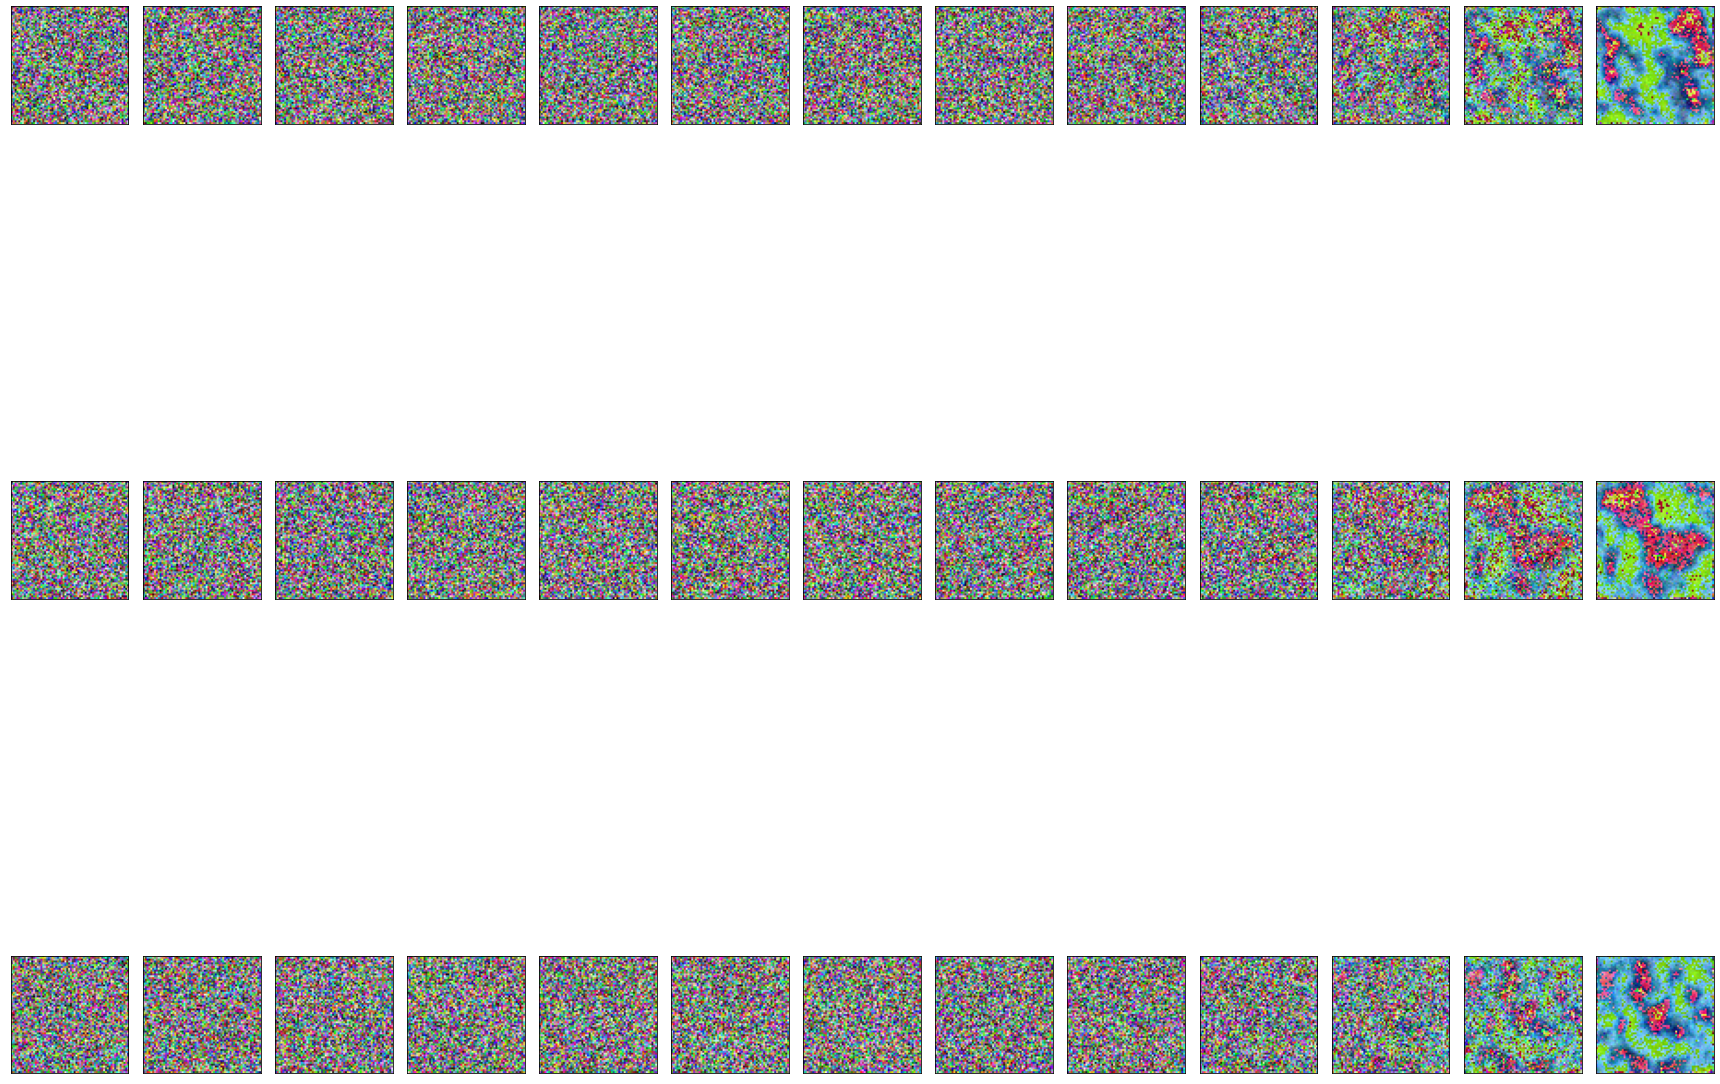

Epoch 5 | step 002/26 Loss: 0.06885981559753418
Epoch 5 | step 003/26 Loss: 0.05128762125968933
Epoch 5 | step 004/26 Loss: 0.12988747656345367
Epoch 5 | step 005/26 Loss: 0.07717776298522949
Epoch 5 | step 006/26 Loss: 0.059278618544340134
Epoch 5 | step 007/26 Loss: 0.09208279848098755
Epoch 5 | step 008/26 Loss: 0.09109457582235336
Epoch 5 | step 009/26 Loss: 0.048552095890045166
Epoch 5 | step 010/26 Loss: 0.06580431759357452
Epoch 5 | step 011/26 Loss: 0.060923170298337936
Epoch 5 | step 012/26 Loss: 0.0867529958486557
Epoch 5 | step 013/26 Loss: 0.11225327104330063


In [ ]:
for epoch in range(1, epochs+1):
    for step, batch in enumerate(dataloader):
        imgs, contexts = batch[0].to(device), batch[1].to(device)
        batch_size = len(imgs)        
        t = torch.randint(0, time_step, (batch_size,), device=device).long()
        
        noise_imgs, noise = ddpm.add_noise(imgs, t)
        pred_noise = unet(noise_imgs, t, contexts)
        
        optimizer.zero_grad()
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch} | step {step+1:03d}/{len(dataloader)} Loss: {loss.item()}")
        
        with torch.no_grad():
            if epoch % 5 == 0 and step == 0:
                ddpm.sample(unet, 3, 64, 18, time_step, 40, plot=True)
    
    # save model periodically
    if epoch%save_epoch==0:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(unet.state_dict(), save_dir + f"model_{epoch}.pth")
        print('saved model at ' + save_dir + f"model_{epoch}.pth")